In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *

import sympy as sym
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif( omega, f, n, bc ):
    '''
    Given the domain interval omega, 
    the forcing function f, 
    the number of discretization points n,
    the boundary conditions bc, 
    finDif returns the matrix A and the the right hand side b
    '''
    assert n>1
    assert omega[1]>omega[0]
    x=np.linspace(omega[0],omega[1],n)
    h = (omega[1]-omega[0])/(n-1)
    a2 = np.ones((n-2,)) # Offdiagonal entries
    a1 = -16 * np.ones((n-1,)) # Offdiagonal entries
    a0 = 30 * np.ones((n,)) # Diagonal entries
    A = (np.diag(a2, -2) + np.diag(a1, -1) + np.diag(a0, 0 )+ np.diag(a1, 1 )+ np.diag(a2, 2))/(12 * h**2)
    b=f(x)
    # Change first row of the matrix A
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]/(h**2)
    # Change last row of the matrix A
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[1]/(h**2)
    return A, b

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    '''
    LU retruns the LU factorization of the system matrix A
    '''
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    L=np.tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = np.triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    '''
    cholesky retruns the Cholesky factorization of the system matrix A
    '''
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = np.zeros_like(rhs)
    N = len(L)
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
    return x

In [7]:
def U_solve(U,rhs):
    x = np.zeros_like(rhs)
    N=len(U)
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N)):
        x[i] = (rhs[i] - np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

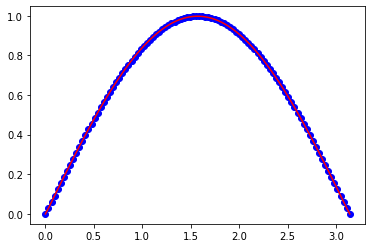

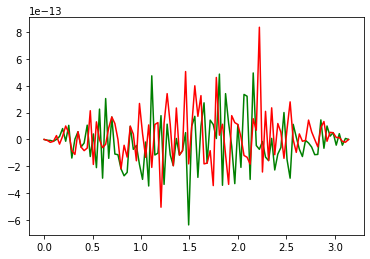

In [8]:
x=np.linspace(omega[0],omega[1],n)
# My solution
w = L_solve(L,b)
u = U_solve(U,w)
# Numpy solution
u_ex = np.linalg.solve(A, b)
# Lets plot
_ = plot(x,u,'o-b')
_ = plot(x,u_ex,'r')
show()
# Compare my solution with exact solution
plot(x,A.dot(u)-np.sin(x),'g')
# Compare scipy with exact solution
plot(x,A.dot(u_ex)-np.sin(x),'r')

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

,n,error
0,2,0.000000
1,3,0.001042
2,4,0.001470
3,5,0.001371
4,6,0.001169
...,...,...
122,124,0.000052
123,125,0.000052
124,126,0.000052
125,127,0.000051


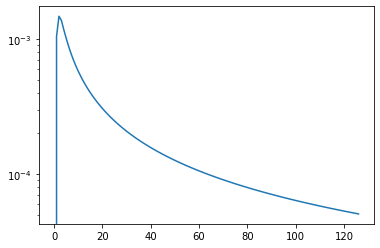

In [9]:
def calculate_error(omega, f, bc, Nmin, Nmax):
    '''
    calculate the error between the LU solution and the function (x2**4)/12. - (x2**3)/6. + x2/12
    given:
    the interval omega
    the forcing force f
    the boundary condictions bc
    as a function of n integer in between Nmin and Nmax
    '''
    errors = []
    N=np.arange(Nmin,Nmax)
    error = 0.
    for n in range(Nmin,Nmax):
        x=np.linspace(omega[0],omega[1],n)
        A, b = finDif(omega, f, n, bc)
        L, U = LU(A)
        w = L_solve(L,b)
        u = U_solve(U,w)
        u_ex =(x**4)/12. - (x**3)/6. + x/12.
        error=max(abs(u-u_ex))
        errors.append(error)
    return N,errors

# Plot the FD and exact solution
omega2 = [0,1]
f2 = lambda x : x*(1-x)
bc2 = [0,0]
m,errors=calculate_error(omega2, f2, bc2, 2, 129)
semilogy(errors)
df = pd.DataFrame({'n' : m, 'error' : errors})  
display(df)
# df.style

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [10]:
def IPM(A, x0, mu, tol, nmax ):
    '''
    Inverse power method with shift:  
    given the matrix A and vector x0, together with the shift mu
    IPM returns eigenvalue close to mu and the relative eigenvector
    with tolerance tol
    or after nmax max iterations 
    '''
    M = A - mu * np.identity(len(A))
    L,U = LU(M)
    err = tol + 1.
    it = 0
    q = x0/np.sqrt(np.dot(x0,x0))
    while it < nmax and err > tol :
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/np.sqrt(np.dot(x,x))
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err =np.sqrt(np.dot(z-l*q,z-l*q))
        it += 1
    return l,q

def PM(A, z0, tol, nmax):
    '''
    Power method:
    given A and z0
    PM returns the maximum eigenvalue and the associated eigenvector
    with tolerance tol
    or after nmax iterations
    '''
    q = z0/np.sqrt(np.dot(z0,z0))
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/np.sqrt(np.dot(z,z))
        it += 1
    return l,q
    

def condNumb(A, eps, tol, nmax):
    '''
    condNumb returns the conditional number of the matrix A
    condNumb uses the power method to find the max eigenvalue
    and the Inverse power method with shift to find the minimum eigenvalue
    We look for the minimum eigenvalue close to zero (regulated by eps) 
    as our matrix is symmetrix positve definite
    The tolerance is tol and we use nmax iterations
    '''
    n = np.shape(A)[0]
    z0 = np.ones(n)
    lmin, _ = IPM(A, z0, eps, tol, nmax)
    lmax, _ = PM( A, z0, tol, nmax)
    condNu = lmax/lmin
    return condNu


print(condNumb(A, 1e-10, 1e-15, 15000 ))
print(np.linalg.cond(A))

5289.611999528572
5294.5980161406715


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

2.5976566662774525e-14
3.996066349120499e-14


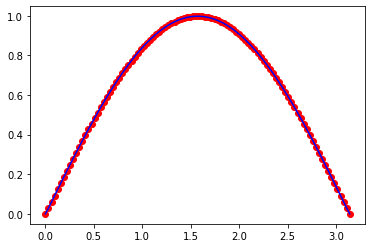

In [11]:
def conjugate_gradient(A, b, P, nmax, eps):
    '''
    Preconditioned Conjugant Gradient method:
    Given the matrix A, the vector b and the preconditioner matrix P
    conjugate_gradient returns the solution of the original system 
    after nmax iterations 
    or with tolerance eps
    '''
    N=len(A)
    x = np.zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = np.dot(A,p)
        alpha = rho/(np.dot(p,q))
        x += p*alpha
        r -= q*alpha
        p_old = p
        rho_old = rho
        tol = np.linalg.norm(r,2)    
    return x



sol_conjugate_gradient = conjugate_gradient(A,b, np.identity(len(A)), 100, 1e-10)
x=np.linspace(omega[0],omega[1],n)
# My solution
L,U = LU(A)
w = L_solve(L,b)
u = U_solve(U,w)
# Scipy solution
u_ex = np.linalg.solve(A, b)
# Lets plot
_ = plot(x,sol_conjugate_gradient,'ro')
_ = plot(x,u_ex,'b')
print(np.linalg.norm(sol_conjugate_gradient - u)/np.linalg.norm(u))
print(np.linalg.norm(sol_conjugate_gradient-u_ex)/np.linalg.norm(u_ex))

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


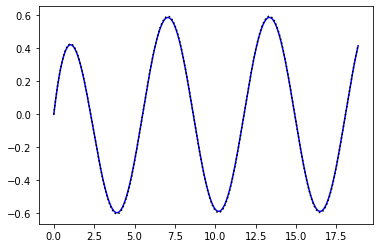

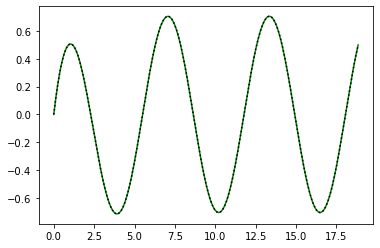

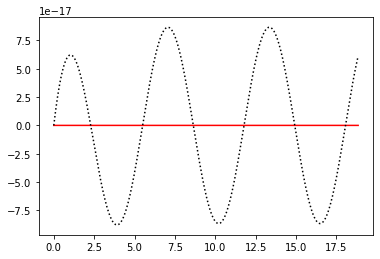

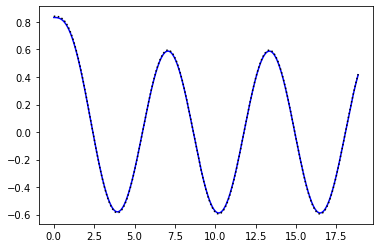

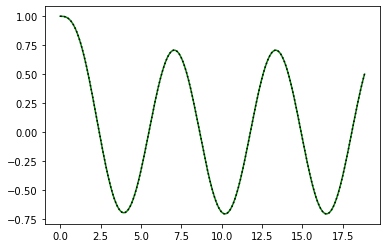

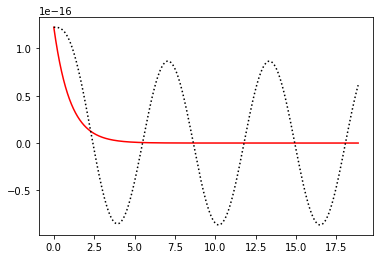

In [12]:
def fe_pde(omega_x, omega_t, bc, y0, h, n, f, eps ):
    '''
    Given the intervals omega_t and omega_x
    with boundary conditions y0 and bc
    h is the time distance between two consecutive nodes
    n is the number of spatial discretization points
    f is the forcing function
    eps a small parameter to calculate the timestep correctly
    fe_pde returns the solutions of the pde with the timesteps and xsteps
    '''
    assert n > 0 
    assert h > 0
    A, b = finDif(omega_x, f, n, bc)
    timesteps = np.arange(omega_t[0],omega_t[1]+eps, h) 
    m = len(timesteps)
    sol = np.zeros((m,n))
    Au = np.zeros((m,n))
    xsteps=np.linspace(omega_x[0],omega_x[1],n)
    sol[0] = y0
    for i in range(0,m-1):
        Au[i] = np.dot(A,sol[i])   
        sol[i+1] = sol[i]  + h *(b*np.cos(timesteps[i])- Au[i] )
    return sol, timesteps, xsteps

def sol_x_fixed(sol, omega_x, x):
    assert x>= omega_x[0]
    assert x<= omega_x[1]
    n = np.shape(sol)[1]
    assert n>0
    x_index = int((n-1)*(x-omega_x[0])//(omega_x[1]-omega_x[0]))
    #if x_index<0: 
    #    x_index=0
    #if x_index>=n: 
    #    x_index=n-1    
    sol_x_fixed = sol[:,x_index]
    return sol_x_fixed

def sol_t_fixed(sol, omega_t, t):
    assert t>= omega_t[0]
    assert t<= omega_t[1]
    m = np.shape(sol)[0]
    assert m>0
    t_index = int((m-1)*(t-omega_t[0])//(omega_t[1]-omega_t[0]))
    #if t_index<0: 
    #    t_index=0
    #if t_index>=m: 
    #    t_index=m-1    
    sol_t_fixed = sol[t_index,:]
    return sol_t_fixed


### Boundary condition y0 = 0

f = lambda x : np.sin(x)
omega_x = [0,np.pi]
omega_t = [0,6*np.pi]
n=100
x=np.linspace(omega[0],omega[1],n)
z0 = np.ones_like(x)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
l_max,_ = PM(A,z0,1e-15,15000)
h = 0.0001
assert h < 2/ abs(l_max)
y0 = 0
sol, tsteps, xsteps = fe_pde(omega_x, omega_t, bc, y0, h, n, f, 1e-10)

# Comparison with exact solution
t= tsteps
sol_t = sol_x_fixed(sol, omega_x, 1)
plot(t,sol_t, 'blue')
plot(t,-(1/2)*np.exp(-t)*np.sin(1)+1/2*np.cos(t)*np.sin(1)+1/2*np.sin(t)*np.sin(1),'black',linestyle='dotted')
show()

sol_t = sol_x_fixed(sol, omega_x,np.pi/2)
plot(t,sol_t,'green')
plot(t,-(1/2)*np.exp(-t)*np.sin(np.pi/2)+1/2*np.cos(t)*np.sin(np.pi/2)+1/2*np.sin(t)*np.sin(np.pi/2),'black',linestyle='dotted')
show()

sol_t = sol_x_fixed(sol, omega_x,np.pi)
plot(t,sol_t, 'red')
plot(t,-(1/2)*np.exp(-t)*np.sin(np.pi)+1/2*np.cos(t)*np.sin(np.pi)+1/2*np.sin(t)*np.sin(np.pi),'black',linestyle='dotted')
show()

### Boundary condition y0 = sin(x)

f = lambda x : np.sin(x)

omega_x = [0,np.pi]
omega_t = [0,6*np.pi]
n=100
x=np.linspace(omega[0],omega[1],n)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
l_max,_ = PM(A,z0,1e-15,15000)
h = 0.0003
assert h < 2/ abs(l_max)
y0 = np.sin(x)

sol, tsteps, xsteps = fe_pde(omega_x, omega_t, bc, y0, h, n, f, 1e-10)

# Comparison with exact solution
t= tsteps
sol_t = sol_x_fixed(sol, omega_x, 1)
plot(t,sol_t, 'blue')
plot(t,(1/2)*np.exp(-t)*np.sin(1)+1/2*np.cos(t)*np.sin(1)+1/2*np.sin(t)*np.sin(1),'black',linestyle='dotted')
show()

sol_t = sol_x_fixed(sol, omega_x, np.pi/2)
plot(t,sol_t,'green')
plot(t,(1/2)*np.exp(-t)*np.sin(np.pi/2)+1/2*np.cos(t)*np.sin(np.pi/2)+1/2*np.sin(t)*np.sin(np.pi/2),'black',linestyle='dotted')
show()

sol_t = sol_x_fixed(sol, omega_x, np.pi)
plot(t,sol_t, 'red')
plot(t,(1/2)*np.exp(-t)*np.sin(np.pi)+1/2*np.cos(t)*np.sin(np.pi)+1/2*np.sin(t)*np.sin(np.pi),'black',linestyle='dotted')
show()



Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [13]:
def lu_eigvalues(A,nmax):
    """
    Given the matrix A lu_eigvalues returns the eigenvalues after nmax iterations
    """
    n = np.shape(A)[0]
    eigvals = np.zeros(n)
    L, U = LU(A)
    it = 0
    new_A = np.ones_like(A)
    while(it<nmax):
        new_A = U@L
        L, U = LU(new_A)
        it = it+1
    eigvals = np.diag(new_A) 
    return eigvals

def eig(A, eps, tol, nmax_eigevalues, nmax_IPM):
    """
    eig returns eigenvalues and eigenvector of A
    eig first finds the approximated eigenvalues using LU decomposition (lueigvals)
    using nmax_eigevalues iterations
    Then Inverse power method with shift to find eigenvalues close to lueigvals and relative eigenvectors
    i.e. we look for the eigenvalue close to the approximated eigenvalue (regulated by eps) 
    with tolerance tol or using nmax_IPM iterations
    """
    n = np.shape(A)[0]
    z0 = np.ones(n)
    eigvals = np.zeros(n)
    eigvecs = np.zeros((n,n))
    lueigvals = lu_eigvalues(A, nmax_eigevalues)
    for i, qre in enumerate(lueigvals):
        eigvals[i], eigvecs[:,i] = IPM(A, z0, qre + eps, tol, nmax_IPM )
    return eigvals, eigvecs

l,v = eig(A, 1e-10, 1e-10, 1500, 15000 )
l_numpy,v_numpy = np.linalg.eig(A)
print(np.sort(l)-np.sort(l_numpy))
print()
print(np.sort(v)-np.sort(v_numpy))
#This algorithm is not efficient, to get accurate results I have to typically set a large number of iterations

[ 2.22044605e-16  2.22044605e-16  2.39808173e-14  1.58983937e-13
 -2.80664381e-13 -1.38555833e-13  4.29878355e-13  2.84217094e-14
  4.33431069e-13  5.68434189e-14  2.84217094e-14  1.42108547e-13
 -4.26325641e-14  8.24229573e-13  1.42108547e-13  1.13686838e-13
  6.82121026e-13  3.97903932e-13  6.82121026e-13  0.00000000e+00
 -1.13686838e-13  0.00000000e+00  1.70530257e-13 -1.64845915e-12
  5.68434189e-13  3.41060513e-13  1.13686838e-12 -5.68434189e-13
  1.13686838e-13 -1.70530257e-12 -3.41060513e-13  1.25055521e-12
  2.38742359e-12  1.13686838e-13  6.82121026e-13  1.59161573e-12
  4.09272616e-12  1.13686838e-12  2.04636308e-12  3.41060513e-12
  6.82121026e-13  6.82121026e-13  1.59161573e-12  6.13908924e-12
 -1.36424205e-12  2.72848411e-12 -5.00222086e-12 -1.81898940e-12
 -1.36424205e-12  1.81898940e-12  1.81898940e-12 -1.36424205e-12
  1.09139364e-11  3.63797881e-12  5.00222086e-12  2.27373675e-12
  5.91171556e-12  1.36424205e-12  4.54747351e-13  0.00000000e+00
 -6.36646291e-12  4.09272

Compute the inverse of the matrix A exploiting the derived LU factorization

In [14]:
def inverse(A):
    """
    inverse returns the inverse of the matrix 
    """
    m = np.shape(A)[0]
    Ainv= np.ones_like(A)
    L,U = LU(A)
    for j in range(m):
        e=np.zeros((m,))
        e[j]=1
        winv = L_solve(L,e)
        uinv = U_solve(U,winv)
        Ainv[:,j]=uinv
    return Ainv    

Ainv = inverse(A)
Ainv_numpy = np.linalg.inv(A)
print(Ainv-Ainv_numpy)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.33680869e-19 -4.33680869e-19 ... -1.82620303e-18
  -8.99548990e-19  0.00000000e+00]
 [ 0.00000000e+00 -7.58941521e-19 -8.67361738e-19 ... -3.78115508e-18
  -1.86008435e-18  0.00000000e+00]
 ...
 [ 0.00000000e+00 -1.80587424e-18 -3.72016870e-18 ... -9.97465999e-18
  -4.98732999e-18  0.00000000e+00]
 [ 0.00000000e+00 -8.70749870e-19 -1.79570985e-18 ... -4.98732999e-18
  -2.38524478e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

0.01808450545115159 0.015748721108820307


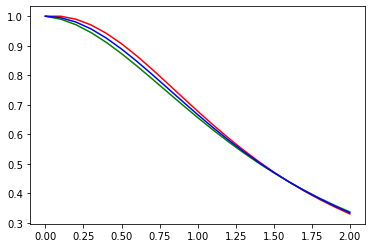

In [15]:
def newton(f, f_prime, x0, eps, n_max):
    '''
    Newton's method:
    f: function
    f_prime: derivative of the function
    x0: initial point
    eps: tolerance
    n_max: max number of iterations
    '''
    err = abs(f(x0))
    it = 0
    x = x0
    while (err > eps and it < n_max):
        if abs(f_prime(x)) < 1e-12:
            raise RuntimeError("f_prime(x) is close to zero")
        x_new = x - f(x)/f_prime(x)
        err = abs(f(x_new))
        x = x_new
        it += 1
    return x

def fe(t0, tf, h, y0, eps=1e-10):
    '''
    Forward Euler's method:
    given
    t0: initial time
    tf: final time
    h: the time distance between two consecutive nodes
    y0: boundary condition at y[t0]
    eps: small epsilon to calculate the time steps
    fe returns the solution of the differential equation and the timesteps
    '''
    timesteps = np.arange(t0,tf+eps, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i] = sol[i-1] - h * timesteps[i-1] * sol[i-1]**2   
    return sol, timesteps


def be(t0, tf, h, y0, tol=1e-10, nmax=1000, eps=1e-10):
    """
    Backward Euler's method:
    given
    t0: initial time
    tf: final time
    h: the time distance between two consecutive nodes
    y0: boundary condition at y[t0]
    eps: small epsilon to calculate the time steps
    tol: tolerance for the iterations
    nmax: max number of iterations
    be returns the solution of the differential equation and the timesteps
    """
    timesteps = np.arange(t0, tf + eps, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    it = 0
    for i in range(len(sol)-1):
        t = sym.symbols('t')
        f_sym = t - sol[i] + h * timesteps[i+1] * t**2 
        f_prime_sym = sym.diff(f_sym,t)
        f = sym.lambdify(t, f_sym, 'numpy')
        f_prime = sym.lambdify(t, f_prime_sym, 'numpy')
        sol[i+1] = newton(f, f_prime, sol[i], tol, nmax) 
    return sol, timesteps

l = -5.
t0 = 0.
tf = 2.
y0 = 1.
s = np.linspace(t0,tf,100)
h=0.1
# h=0.01 
f_exact = lambda x: 2/(2 + x**2)
f_fe, t = fe(t0, tf, h, y0)
f_be, t = be(t0, tf, h, y0)
_ = plot(t, f_fe, 'r')
_ = plot(t, f_be, 'g')
_ = plot(t, f_exact(t), 'b')
error1 = max(abs(f_exact(t) - f_fe))
error2 = max(abs(f_exact(t) - f_be))
print(error1, error2)